# Waveform Tutorial - LVK Meeting September 2022

Welcome to the tutorial on waveform generation with `LALSuite`, including an overview of the new waveform interface written in both C and Python. Prerequisite for this tutorial is a basic, working knowledge of Python.


## Gravitational Waveforms

This tutorial will focus on gravitational waves (GW) generated by Compact Binary Coalescences (CBC), such as coalescing binary black holes (BBH), binary neutron stars (BNS) and neutron star - black holes (NSBH). Any modeled GW generated by a CBC depends on a set of intrinsic parameters, like the masses and spins of the system, and extrinsic parameters, like the sky position and distance to the source. 

Mathematically, a GW $h(t)$ can be written as:

$h(t, \vec{\lambda}) = \mathcal{A}(t, \vec{\lambda})\, e^{i \psi(t, \vec{\lambda})} $,

where $\mathcal{A}$ and $\psi$ are the amplitude and phase of the GW, respectively. A GW $h(t)$ may contain information about both the plus $(h_{+}(t))$ and cross $(h_{\times}(t))$ polarizations. In terms of the polarizations, the waveform strain is defined as

$h(t) = h_{+}(t) - ih_{\times}(t)$.
    
Depending on the configuration of the system, a CBC can be classified as being *non-spinning*, having *aligned spins*, or being *precessing*. We will look at each of these categories in slight detail as we progress through the tutorial. Note that for this tutorial, we will focus solely on BBH systems.


# Generate Time-domain (TD) Waveforms using `LALSimulation`

The goals for this section are to:
* Understand the parameter dictionary used to generate a waveform
* Generate a TD waveform from `LALSimulation` in python
* Develop basic intuition for waveform dependence on certain parameters

To generate a waveform, we first need to import the required modules (along with the modules used for the rest of the tutorial).

In [ ]:
# Import modules
import lalsimulation as lalsim
import lal
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import pygrav as pg
import astropy.units as u

# make a dictionary to store a bunch of things to come
h = dict()

# ignore this jumble of output

### Non-spinning BBH
We now define a python dictionary for the parameters of our first binary. Here, we will specify an equal-mass, non-spinning BBH waveform and generate the TD polarizations using the `IMRPhenomTPHM` approximant.

By *non-spinning* we mean that each constituent black hole in the system has zero intrinsic angular momentum, so the orbital angular momentum of the binary constitutes the total angular momentum of the system.

Note that below, the parameters must be specified using SI units. We can write the mass parameters `m1` and `m2` in terms of solar masses, then convert using the built-in `LAL` conversions. This also works when converting the distance from parsecs to meters.

In [ ]:
td_params_nonspinning = {
 'm1': 20*lal.MSUN_SI, # Mass of BH1 in kg
 'm2': 20*lal.MSUN_SI, # Mass of BH2 in kg
 'S1x': 0.0,
 'S1y': 0.0,
 'S1z': 0.0,
 'S2x': 0.0,
 'S2y': 0.0,
 'S2z': 0.0,
 'distance': 1e6*lal.PC_SI, # Distance of 1MPC
 'inclination': 0., # Face-on System
 'phiRef': 0., 
 'longAscNodes': 0.0,
 'eccentricity': 0.0,
 'meanPerAno': 0.0,
 'f_min': 20.0,
 'f_ref': 20.0,
 'deltaT': 1./1024.,
 'approximant': lalsim.IMRPhenomTPHM, # Name of approximant tag in LALSimulation
 'LALparams': None}

To access the waveform generating C-functions written in `LALSimulation`, we use the SWIG-wrapped function `SimInspiralTD` which will return $h_{+}$ and $h_{\times}$ parameterized by the time $t$.

Note the peculiar way in which the data is stored in the timeseries objects, e.g. `hp.data.data`.

In [ ]:
# pass our parameter dictionary into SimInspiralTD
hp, hc = lalsim.SimInspiralTD(**td_params_nonspinning)

# store the output in a dictionary so we can call it later. We'll use 'ns' to denote non-spinning
h['ns'] = dict()
h['ns']['plus'] = hp.data.data
h['ns']['cross'] = hc.data.data

# generate the timeseries for our data from its length, the timestep, and the timeshift
data_length = len(hp.data.data)
dt = hp.deltaT
h['ns']['tshift'] = hp.epoch.gpsSeconds + hp.epoch.gpsNanoSeconds/1e9

h['ns']['t'] = np.arange(data_length) * dt + h['ns']['tshift']

The purpose of the timeshift, `hp.epoch`, is to translate the data so that the strain amplitude peaks at approximately $t=0$.

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].plot(h['ns']['t'], h['ns']['plus'], 'r')
axs[1].plot(h['ns']['t'], h['ns']['cross'], 'b')

for ax, sym in zip(axs,['+','\\times']):
    ax.set_xlabel(r'$t$ [sec]')
    ax.set_ylabel(rf'$h_{sym}(t)$')

plt.show()

### Aligned-spin BBH
Next, we will generate the waveform polarizations for a BBH with the same masses but with aligned spins, specifying that the black holes each now have some intrinsic angular momentum parallel to the oribtal angular momentum of the binary.

In [ ]:
td_params_alignedspin = {
 'm1': 20*lal.MSUN_SI, # Mass of BH1 in kg
 'm2': 20*lal.MSUN_SI, # Mass of BH2 in kg
 'S1x': 0.0,
 'S1y': 0.0,
 'S1z': 0.5, # some spin aligned with L
 'S2x': 0.0,
 'S2y': 0.0,
 'S2z': 0.2, # some spin aligned with L
 'distance': 1e6*lal.PC_SI, # Distance of 1MPC
 'inclination': 0., # Face-on System
 'phiRef': 0., 
 'longAscNodes': 0.0,
 'eccentricity': 0.0,
 'meanPerAno': 0.0,
 'f_min': 20.0,
 'f_ref': 20.0,
 'deltaT': 1./1024.,
 'approximant': lalsim.IMRPhenomTPHM, # Name of approximant tag in LALSimulation
 'LALparams': None}

In [ ]:
# pass our parameter dictionary into SimInspiralTD
hp, hc = lalsim.SimInspiralTD(**td_params_alignedspin)

h['as'] = dict()
h['as']['plus'] = hp.data.data
h['as']['cross'] = hc.data.data

# generate the timeseries for our data from its length, the timestep, and the timeshift
data_length = len(hp.data.data)
dt = hp.deltaT
h['as']['tshift'] = hp.epoch.gpsSeconds + hp.epoch.gpsNanoSeconds/1e9


h['as']['t'] = np.arange(data_length) * dt + h['as']['tshift']

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].plot(h['as']['t'], h['as']['plus'], 'r')
axs[1].plot(h['as']['t'], h['as']['cross'], 'b')

for ax, sym in zip(axs,['+','\\times']):
    ax.set_xlabel(r'$t$ [sec]')
    ax.set_ylabel(rf'$h_{sym}(t)$')

plt.show()

We know what you're thinking... "those plots dont' look any different!"

The effect of aligned spins can be subtle; let's compare the plus polarizations between the non-spinning and aligned-spin systems to see what's happening. We'll also revert the timeshift to make the effect clearer.

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(h['ns']['t'] - h['ns']['tshift'], h['ns']['plus'], c='k', label='non-spinning')
plt.plot(h['as']['t'] - h['as']['tshift'], h['as']['plus'], c='r', label='aligned-spin')

plt.xlabel(r'$t$ [sec]')
plt.ylabel(r'$h_+(t)$')
plt.legend()

plt.show()

As both of these signals were generated from binary systems with the same total mass and starting frequency (the `f_min` value in the parameter dictionary), we see that they start looking very similar in terms of phase and amplitude. Note however that the system with spinning black holes has a longer duration before merging; this is the "hang-up effect" in action!

### Exercise : 
* Generate an `IMRPhenomTPHM` waveform with anit-aligned spins (negative `S1z` and `S2z`), store it in the `h` dictionary as `h['anti_as']` and compare the waveform with the non-spinning waveform. What do you see when the spins are anti-aligned? 

### Precessing BBH
Next, we generate the waveform polarizations for a BBH with the same masses but with *precessing* spins. Spin-induced precession for a BBH occurs when the direction of the spins is no longer (anti-)parallel to the orbital angular momentum, causing amplitude modulations to arise in the GW. 

In [ ]:
td_params_precessing = {
 'm1': 20*lal.MSUN_SI, # Mass of BH1 in kg
 'm2': 20*lal.MSUN_SI, # Mass of BH2 in kg
 'S1x': 0.8,
 'S1y': 0.1,
 'S1z': 0.0, # note the component of the spins aligned with the orbital angular momentum are set to zero
 'S2x': 0.9,
 'S2y': 0.2,
 'S2z': 0.0, # note the component of the spins aligned with the orbital angular momentum are set to zero
 'distance': 1e6*lal.PC_SI, # Distance of 1MPC
 'inclination': 0., # Face-on System
 'phiRef': 0., 
 'longAscNodes': 0.0,
 'eccentricity': 0.0,
 'meanPerAno': 0.0,
 'f_min': 20.0,
 'f_ref': 20.0,
 'deltaT': 1./1024.,
 'approximant': lalsim.IMRPhenomTPHM, # Name of approximant tag in LALSimulation
 'LALparams': None}

In [ ]:
# pass our parameter dictionary into SimInspiralTD
hp, hc = lalsim.SimInspiralTD(**td_params_precessing)

h['ps'] = dict()
h['ps']['plus'] = hp.data.data
h['ps']['cross'] = hc.data.data

# generate the timeseries for our data from its length, the timestep, and the timeshift
data_length = len(hp.data.data)
dt = hp.deltaT
h['ps']['tshift'] = hp.epoch.gpsSeconds + hp.epoch.gpsNanoSeconds/1e9


h['ps']['t'] = np.arange(data_length) * dt + h['ps']['tshift']

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].plot(h['ps']['t'], h['ps']['plus'], 'r')
axs[1].plot(h['ps']['t'], h['ps']['cross'], 'b')

for ax, sym in zip(axs,['+','\\times']):
    ax.set_xlabel(r'$t$ [sec]')
    ax.set_ylabel(rf'$h_{sym}(t)$')

plt.show()

Again, let's just briefly compare with the non-spinning waveform.

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(h['ns']['t'] - h['ns']['tshift'], h['ns']['plus'], 'k', label='non-spinning')
plt.plot(h['ps']['t'] - h['ps']['tshift'], h['ps']['plus'], 'r', label='precessing spins')

plt.xlabel(r'$t$ [sec]')
plt.ylabel(r'$h_+(t)$')
plt.legend()

plt.show()

In this case, the black holes in the precessing system have no spin in the direction of the orbital angular momentum, so the phase evolution and duration of the precessing signal is roughly equal to that of the non-spinning signal. We do see amplitude modulations in the precessing signal, making the amplitude no longer a purely monotonic function!

### Impact of Inclination

To finish our introduction to TD waveforms, we'll look at how the various signals produced above are modified by changing the `inclination` value in the parameter dictionary. The inclination determines the angle between the binary's orbital angular momentum and the line-of-sight vector to a distant observer (specified at the reference frequency value `f_ref`). Currently all of the signals have been generated with an inclination value of zero (a so-called "face on" view).

We first vary inclination for the non-spinning signal.

In [ ]:
# let's choose an inclination of 90 degrees, an "edge on" view placing the observer in the binary's orbital plane
inclination = np.pi / 2.0

# we can modify the parameter dictionary, rather than having to make a new one
td_params_nonspinning['inclination'] = inclination

# pass our parameter dictionary into SimInspiralTD
hp, hc = lalsim.SimInspiralTD(**td_params_nonspinning)

h['ns-inclined'] = dict()
h['ns-inclined']['plus'] = hp.data.data
h['ns-inclined']['cross'] = hc.data.data

# generate the timeseries for our data from its length, the timestep, and the timeshift
data_length = len(hp.data.data)
dt = hp.deltaT
h['ns-inclined']['tshift'] = hp.epoch.gpsSeconds + hp.epoch.gpsNanoSeconds/1e9

h['ns-inclined']['t'] = np.arange(data_length) * dt + h['ns-inclined']['tshift']

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].plot(h['ns']['t'], h['ns']['plus'], 'k', alpha=0.3, label='face on')
axs[1].plot(h['ns']['t'], h['ns']['cross'], 'k', alpha=0.3, label='face on')

axs[0].plot(h['ns-inclined']['t'], h['ns-inclined']['plus'], 'r', label='edge on')
axs[1].plot(h['ns-inclined']['t'], h['ns-inclined']['cross'], 'b', label='edge on')

for ax, sym in zip(axs,['+','\\times']):
    ax.set_xlabel(r'$t$ [sec]')
    ax.set_ylabel(rf'$h_{sym}(t)$')
    ax.legend()

plt.show()

Here we see the amplitude of the plus polarization reduced by a factor of two, and the cross polarization is entirely eliminated.

### Exercise:

* Generate a waveform using the precessing parameters specified above at an inclination of 90 degrees, and plot the plus and cross polarizations for both inclinations. 
* How does this signal compare to the non-spinning waveform?

# Generate Frequency-domain (FD) Waveforms using LALSimulation

The goal for this section is to:
* Generate FD waveforms from `LALSimulation` in python

Let us now generate frequency-domain waveforms for the same precessing system as above.

In [ ]:
fd_params_precessing = {
 'm1': 20*lal.MSUN_SI, # Mass of BH1 in kg
 'm2': 20*lal.MSUN_SI, # Mass of BH2 in kg
 'S1x': 0.8,
 'S1y': 0.1,
 'S1z': 0.0,
 'S2x': 0.6,
 'S2y': 0.3,
 'S2z': 0.0,
 'distance': 1e6*lal.PC_SI, # Distance of 1MPC
 'inclination': 0., # Face-on System
 'phiRef': 0., 
 'longAscNodes': 0.0,
 'eccentricity': 0.0,
 'meanPerAno': 0.0,
 'f_min': 20.0,
 'f_ref': 20.0,
 'f_max': 2048.0,
 'deltaF': 1./1024.,
 'approximant': lalsim.IMRPhenomXPHM, # Name of approximant
 'LALparams': None}

In [ ]:
# we now call SimInspiralFD to produce our frequency-domain waveform (instead of SimInspiralTD...)
hp, hc = lalsim.SimInspiralFD(**fd_params_precessing)

frequencies = np.arange(len(hp.data.data))*hp.deltaF

h['fd-ps'] = dict()
h['fd-ps']['plus'] = hp.data.data
h['fd-ps']['cross'] = hc.data.data
h['fd-ps']['freq'] = frequencies

In [ ]:
plt.loglog(h['fd-ps']['freq'], np.abs(h['fd-ps']['plus']))
plt.xlim(20., 2048.)
plt.xlabel(r'$f$ [Hz]')
plt.ylabel(r'$\tilde{h}_+(f)$')
plt.show()

### Quiz:

* Which different parameters are used to generate a frequency domain waveform compared to a time domain waveform? 

### Exercise:

* Generate and plot a frequency domain waveform for a non-equal mass and inclined precessing system using `IMRPhenomXPHM`. 

# New Waveform interface

Thus far we have been generating waveforms using the legacy SWIG-wrapped `LALSimulation` interface. Let us now begin using the new interface for waveform generation!

The new waveform interface is constructed with the vision of having a code-base where a waveform can be developed either in C or in Python, implemented in the C version of the interface (i.e., in `LALSimulation`) or in the Python and be callable from either language. 

This schematic image demonstrates the general flow of the new interface.

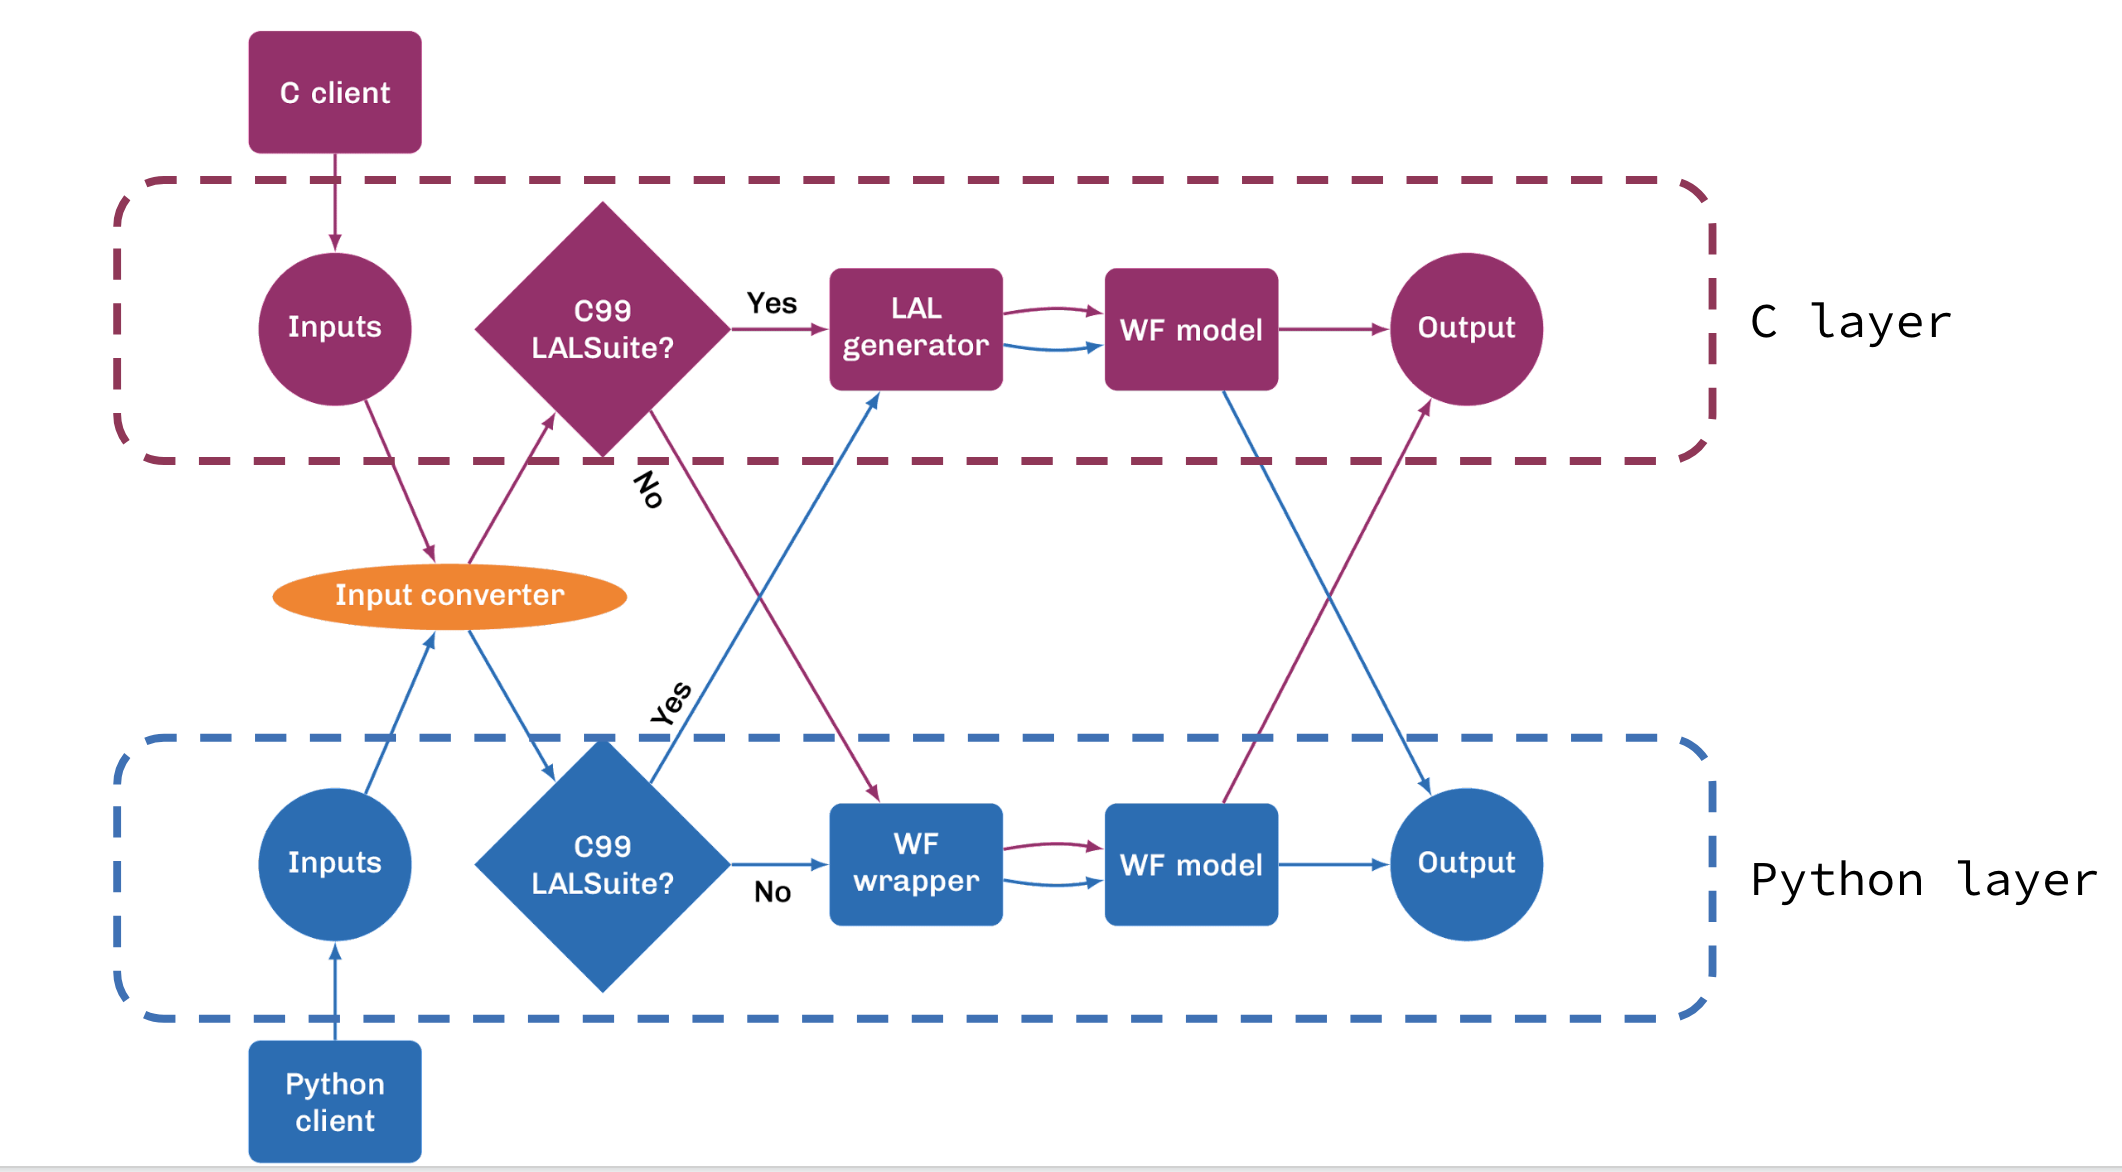

We will now walk through a brief introduction to both the C and Python clients of the new interface.

## New C-based Interface

For the new C-based interface, the waveform generation procedure follows a similar flow to the old `LALSimulation` interface: define a dictionary of system parameters, choose an approximant *generator* and then use the `SimInspiralGenerateTD/FDWaveform` functions to produce our signals.

First, let's generate an equal-mass, aligned-spin `IMRPhenomTPHM` waveform. You'll notice that there are a few differences with the new parameter dictionary. In particular, some of the parameter names have been changed, and we no longer specify an approximant when defining the parameter dictionary. 

(**NOTE**: The parameter name definitions used in this tutorial may differ from the names used in the final version of the new interface. )

In [ ]:
td_params = {
 'mass1': 40*lal.MSUN_SI, # Mass of BH1 in kg
 'mass2': 20*lal.MSUN_SI, # Mass of BH2 in kg
 'spin1x': 0.,
 'spin1y': 0.,
 'spin1z': 0.5,
 'spin2x': 0.,
 'spin2y': 0.,
 'spin2z': 0.5,
 'distance': 1e6*lal.PC_SI, # Distance of 1MPC
 'inclination': 0.0,
 'phi_ref': 0., 
 'longAscNodes': 0.0,
 'eccentricity': 0.0,
 'meanPerAno': 0.0,
 'f22_start': 20.0,
 'f22_ref': 20.0,
 'deltaT': 1./1024.}

We next convert this python dictionary into a SWIG-wrapped `LAL` dictionary object for use with the C-code. Then we specify the approximant we wish to use and initialize its generator.

We are still using SWIG-wrapped functions out of `LALSimulation`, and the output polarizations are identical in structure to those from the legacy `LALSimulation` interface.

In [ ]:
# Convert the input arguments into a LAL dictionary
generator_laldict = pg.core.utils.to_lal_dict(td_params)

# Define here the approximant to be used and call its generator
approx = lalsim.IMRPhenomTPHM
generator = lalsim.SimInspiralChooseGenerator(approx, generator_laldict)

# Polarizations in TD
hp, hc = lalsim.SimInspiralGenerateTDWaveform(generator_laldict, generator)
times = np.arange(len(hp.data.data))*hp.deltaT + hp.epoch.gpsSeconds + hp.epoch.gpsNanoSeconds/1e9

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].plot(times, hp.data.data, 'r')
axs[1].plot(times, hc.data.data, 'b')

for ax, sym in zip(axs,['+','\\times']):
    ax.set_xlabel(r'$t$ [sec]')
    ax.set_ylabel(rf'$h_{sym}(t)$')

plt.show()

### Exercise

* Generate a waveform with the same parameters as above, but using the `lalsim.IMRPhenomD` approximant. Note: You do not need to change the parameter dictionary!
* You'll notice that the output looks a little different when using `IMRPhenomD` compared to `IMRPhenomTPHM`. Can you think of why?

### Generating a waveform for the same physical system but with different input parameters

With the new interface, you can generate waveforms using different sets of input parameters. This provides additional flexibility for codes that interface with waveform generation but don't intrinsically use the same default parameters as `LALSimulation`. 

Till now, we have used the individual masses of the BHs and the Cartesian spin values (spin1(x-y-z) etc.) to specify the system. Let's now try a different combination of parameters. 

In [ ]:
# define the spherical-polar components to the spin vectors
spin1_norm, spin1_tilt, spin1_phi = 0.5, 0., 0.
spin2_norm, spin2_tilt, spin2_phi = 0.5, 0., 0.

# component masses used earlier
m1 = 40.
m2 = 20.

#define the total mass and mass ratio
total_mass = m1 + m2
mass_ratio = m1/m2

generator_params = {
 'total_mass': total_mass*lal.MSUN_SI,
 'mass_ratio': mass_ratio, 
 'spin1_norm': spin1_norm,       
 'spin1_tilt': spin1_tilt,
 'spin1_phi': spin1_phi,
 'spin2_norm': spin2_norm,       
 'spin2_tilt': spin2_tilt,
 'spin2_phi': spin2_phi,
 'distance': 1e6*lal.PC_SI,
 'inclination': 0.0,
 'phi_ref': 0.,
 'longAscNodes': 0.0,
 'eccentricity': 0.0,
 'meanPerAno': 0.0,
 'f22_start': 20.0,
 'f22_ref_spin': 20.0,
 'deltaT': 1/1024.,
}

In [ ]:
# Convert the input arguments into a lal dictionary. 
generator_laldict = pg.core.utils.to_lal_dict(generator_params)

# Define here the approximant to be used
approx = lalsim.IMRPhenomTPHM
generator = lalsim.SimInspiralChooseGenerator(approx, generator_laldict)

In [ ]:
# Polarizations in Time domain
hp, hc = lalsim.SimInspiralGenerateTDWaveform(generator_laldict, generator)
times = np.arange(len(hp.data.data))*hp.deltaT + hp.epoch.gpsSeconds + hp.epoch.gpsNanoSeconds/1e9

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].plot(times, hp.data.data, 'r')
axs[1].plot(times, hc.data.data, 'b')

for ax, sym in zip(axs,['+','\\times']):
    ax.set_xlabel(r'$t$ [sec]')
    ax.set_ylabel(rf'$h_{sym}(t)$')

plt.show()

### Full set of Parameter Names for use in the Waveform Interface

The full list of available parameters to be used in the generator dictionary for the new C-interface is given here.

**NOTE** the current parameter names both in the C-based and python-based interface are changing, so the names used here are not final!

Parameter | Description 
--- | --- 
mass1 | primary mass, Msun   
mass2 | secondary mass, Msun  
total_mass | total mass of the binary, Msun
mass_ratio | mass ratio (we allow the mass ratio to be >= 1 or <= 1), dimensionless
sym_mass_ratio | symmetric mass ratio, dimensionless
chirp_mass | chirp mass, Msun
mass_difference | mass difference, Msun
reduced_mass | reduced mass, Msun
spin1x | x-component of the primary spin in source frame, dimensionless
spin1y | y-component of the primary spin in source frame, dimensionless
spin1z | z-component of the primary spin in source frame, dimensionless
spin1_norm | norm of the primary spin in source frame, dimensionless
spin1_tilt | polar angle of the primary spin in source frame, rad
spin1_phi | azimuthal angle of the primary spin in source frame, rad
spin2x | x-component of the secondary spin in source frame, dimensionless
spin2y | y-component of the secondary spin in source frame, dimensionless
spin2z | z-component of the secondary spin in source frame, dimensionless
spin2_norm | norm of the secondary spin in source frame, dimensionless
spin2_tilt | polar angle of the secondary spin in source frame, rad
spin2_phi | azimuthal angle of the secondary spin in source frame, rad
phi_ref | reference orbital phase, rad
f22_ref | reference frequency of the (2,2) GW harmonic at which the spin components are specified, Hz
f22_start | starting frequency of the (2,2) GW harmonic, Hz
f_max | maximum frequency value, Hz 
deltaF | sampling fequency interval, Hz
deltaT | sampling time interval, s
distance | distance, m
inclination | inclination angle, rad
longAscNodes | longitude of ascending nodes, degenerate with the polarization angle, rad
eccentricity | eccentricity at reference epoch, dimensionless
meanPerAno | mean anomaly of periastron, dimensionless
approximant | waveform model name


### Exercise  
    
* Use a different set of mass parameters than we have already used and generate an `IMRPhenomTPHM` waveform. 
* We will still require the same number of parameters to specify a system regardless of the parameters chosen; how many parameters are therefore required to fully specify the mass and spin information of a BBH binary?

## Using the native Python Interface

Now it is time to start working with the new interface component that exists solely in python. This package is presently called `PyGrav`, and will allow groups to write waveform models native to python without having to interface with the waveform generation code through `LALSimulation`. It also benefits from added functionality provided by the `astropy` package to specify the units input into the waveform dictionary. Furthermore, the output waveform from the python generator is a `GWpy` time/frequency series, rather than a SWIG-wrapped array.

Let's look at an example of how to produce a waveform using `PyGrav` with `astropy` units.

**NOTE** the current parameter names both in the C-based and python-based interface are changing, so the names used here are not final!

In [ ]:
# Define the parameters of waveform

# masses are given in solar mass units
m1 = 20.*u.solMass
m2 = 20.*u.solMass

# the spins are dimensionless
s1x = 0.*u.dimensionless_unscaled
s1y = 0.*u.dimensionless_unscaled
s1z = 0.*u.dimensionless_unscaled
s2x = 0.*u.dimensionless_unscaled
s2y = 0.*u.dimensionless_unscaled
s2z = 0.*u.dimensionless_unscaled

# we specify the distance in Mpc
distance = 1000.*u.Mpc

# other parameters are given in SI
deltaT = 1./1024.*u.s
f_min = 20.*u.Hz
f_ref = 20.*u.Hz
inclination = 0.*u.rad

phiRef = 0.*u.rad
eccentricity = 0.*u.dimensionless_unscaled
longAscNodes = 0.*u.dimensionless_unscaled
meanPerAno = 0.*u.dimensionless_unscaled

approximant = 'IMRPhenomTPHM'

python_dict = {'mass1' : m1,
              'mass2' : m2,
              'spin1x' : s1x,
              'spin1y' : s1y,
              'spin1z' : s1z,
              'spin2x' : s2x,
              'spin2y' : s2y,
              'spin2z' : s2z,
              'deltaT' : deltaT,
              'f22_start' : f_min,
              'f22_ref': f_ref,
              'phi_ref' : phiRef,
              'phi_co' : phiRef,
              'distance' : distance,
              'inclination' : inclination,
              'eccentricity' : eccentricity,
              'longAscNodes' : longAscNodes,
              'meanPerAno' : meanPerAno}

What follows next is very similar to the new C-based interface (by design!), whereby we choose a generator based on the desired approximant, then call the waveform using the parameter dictionary and waveform generator.

In [ ]:
# Choose a waveform generator using the approximant name specified above
gen = pg.LALCompactBinaryCoalescenceGenerator(approximant)

In [ ]:
# When called as hp, hc
hp, hc = pg.GenerateTDWaveform(python_dict, gen)

# the output will be the GWpy TimeSeries hp, hc 
type(hp)

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,5))

# note that the polarizations store their own timeseries and timeshift!
axs[0].plot(hp.times, hp, 'r')
axs[1].plot(hc.times, hc, 'b')

for ax, sym in zip(axs,['+','\\times']):
    ax.set_xlabel(r'$t$ [sec]')
    ax.set_ylabel(rf'$h_{sym}(t)$')

plt.show()

The data structure of the output polarizations makes it much simpler to work with `GWpy` objects!

### Exercise:

* Using `astropy`, convert the mass and distance values used above to be in SI units.

In [ ]:
# example hint
# suppose we define something to be in centimeters
length_in_cm = 10.0 * u.cm

# to convert to meters, we have a few options:
# - use the `si` module
# - explicitly convert to SI using the `to` method
length_in_m_1 = length_in_cm.si
length_in_m_2 = length_in_cm.to(u.m)

print(length_in_m_1,',', length_in_m_2)

## Automatic Domain Transformations

The new interface also extends functionality within `LALSimulation` to call a waveform model in both the time and frequency domain, regardless of the native domain of the model. This includes appropriate conditioning to reduce artifacting from the FFT/iFFT.

Using a model in a domain for which it is not native is easy! Simply use the approximant generator in whichever `GenerateTD/FDWaveform` function you like! **NOTE: this is functionality presently in development!**

In [ ]:
# To generate a frequency-domain waveform using IMRPhenomXPHM using the parameters from above, simply do:

gen = pg.LALCompactBinaryCoalescenceGenerator('IMRPhenomXPHM')
hp, hc = pg.GenerateFDWaveform(python_dict, gen)

# the output is a FrequencySeries object
type(hp)

In [ ]:
plt.loglog(hp.frequencies,abs(hp))
plt.xlim(20., 2048.)
plt.xlabel(r'$f$ [Hz]')
plt.ylabel(r'$\tilde{h}_+(f)$')
plt.show()

But we can also call the TD waveform from the same approximant:

In [ ]:
# To generate a time-domain waveform of the same signal, simply do:

hp, hc = pg.GenerateTDWaveform(python_dict, gen)
type(hp)

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].plot(hp.times, hp, 'r')
axs[1].plot(hc.times, hc, 'b')

for ax, sym in zip(axs,['+','\\times']):
    ax.set_xlabel(r'$t$ [sec]')
    ax.set_ylabel(rf'$h_{sym}(t)$')

plt.show()

Notice the long taper present in the TD data! As the waveform is native to the frequency domain, it must be modified appropriately to ensure that this tail and taper (arising from the iFFT) do not interfere with the data over the frequency range requested in the parameter dictionary. This is conditioning that is done by the waveform generation code, or can be specified in the waveform generator by the model authors.

# About Modes and Polarizations

Until now, we have worked with the gravitational wave polarizations, $h_{+}$ and $h_{\times}$. One can, however, also write a gravitational waveform in terms of its spherical harmonic modes. 

The waveform strain $h(t)$ can be decomposed in terms of spherical harmonic modes following: 
    
$h(t) = \sum_{\ell, m} h_{\ell, m} Y_{\ell, m}^{-2}(\theta, \varphi)$

where $Y_{\ell, m}^{-2}(\theta, \varphi)$ are the spin-weight -2 spherical harmonics.
    
In this next part, we will generate the spherical harmonic modes for the `NRSur7dq4` surrogate waveform model. 

## Calling a waveform defined only in the python interface

We will now demonstrate how one can call a waveform model written natively in python using `PyGrav`.

In [ ]:
# start with the usual parameter definitions
m1 = 50.*u.solMass
m2 = 50.*u.solMass
s1x = 0.*u.dimensionless_unscaled
s1y = 0.*u.dimensionless_unscaled
s1z = 0.*u.dimensionless_unscaled
s2x = 0.*u.dimensionless_unscaled
s2y = 0.*u.dimensionless_unscaled
s2z = 0.*u.dimensionless_unscaled

deltaT = 1./1024.*u.s
f_min = 20.*u.Hz
f_ref = 20.*u.Hz
distance = 1000.*u.Mpc
inclination = 0.*u.rad

phiRef = 0.*u.rad
eccentricity = 0.*u.dimensionless_unscaled
longAscNodes = 0.*u.dimensionless_unscaled
meanPerAno = 0.*u.dimensionless_unscaled

python_dict_nrsur = {'mass1' : m1,
              'mass2' : m2,
              'spin1x' : s1x,
              'spin1y' : s1y,
              'spin1z' : s1z,
              'spin2x' : s2x,
              'spin2y' : s2y,
              'spin2z' : s2z,
              'deltaT' : deltaT,
              'f22_start' : f_min,
              'f_ref': f_ref,
              'phi_ref' : phiRef,
              'phi_co' : phiRef,
              'distance' : distance,
              'inclination' : inclination,
              'eccentricity' : eccentricity,
              'longAscNodes' : longAscNodes,
              'meanPerAno' : meanPerAno}

Now we load the generator (which presently is written in `PyGrav` as an example, but doesn't have to be).

During the first run-through, you might get a message saying "Surrogate data not found for NRSur7dq4. Downloading now."

In [ ]:
gen = pg.gwsurr.NRSur7dq4_gwsurr()

It's now a simple matter to generate a dictionary of modes by passing the generator and parameter dictionary into `GenerateTDModes`, the output of which is a python dictionary indexed by the spherical harmonic mode number $(\ell, m)$.

In [ ]:
hlm = pg.GenerateTDModes(python_dict_nrsur, gen)

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(hlm['time_array'], hlm[(2,2)].real, 'r', label=r'$h_{2,2}(t)$')
plt.plot(hlm['time_array'], hlm[(2,-2)].real, 'k--', label=r'$h_{2,-2}(t)$')

plt.xlabel(r'$t$ [sec]')
plt.legend()
plt.show()

Notice how we called the individual modes by passing the $(\ell,m)$ value as a key into the dictionary. 

The waveform modes object returned by the python interface is also structure that can compute the plus and cross polarizations, explicitly performing the sum over modes defined above at the given $(\theta,\varphi)$ values.

In [ ]:
theta = 0.2
phi = 0.5
gwp = hlm(theta, phi)

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].plot(gwp.hp.times, gwp.hp, 'r')
axs[1].plot(gwp.hc.times, gwp.hc, 'b')

for ax, sym in zip(axs,['+','\\times']):
    ax.set_xlabel(r'$t$ [sec]')
    ax.set_ylabel(rf'$h_{sym}(t)$')

plt.show()

### Exercise :

* Generate the TD modes using the python interface for the `IMRPhenomTPHM` waveform model using the parameters defined above, and plot the (2,2),  (2,1) and (3,3) modes. 
* Then, generate and plot the strain polarizations for $(\theta, \varphi) = (\pi/2, \pi/6)$.

# Gravitational wave detector strain

We have seen how to generate the gravitational wave polarizations and gravitational wave modes. The gravitational wave signal as seen by the detector depends on the "detector response" to the gravitational wave polarizations. 

The detector response functions, $F_{+}$ and $F_{\times}$, depend on the sky position of the system, the polarization angle and time of arrival of the signal, with the final gravitational strain being:
    
$ h(t) = F_{+} h_{+} + F_{\times} h_{\times}$.
    
We can generate the detector strain very easily from the python interface. First, we generate an instance of the Gravitational Wave Polarizations class (using `pg.GenerateTDWaveform`). 

In [ ]:
# Define the parameters of waveform

m1 = 20.*u.solMass
m2 = 20.*u.solMass
s1x = 0.*u.dimensionless_unscaled
s1y = 0.*u.dimensionless_unscaled
s1z = 0.*u.dimensionless_unscaled
s2x = 0.*u.dimensionless_unscaled
s2y = 0.*u.dimensionless_unscaled
s2z = 0.*u.dimensionless_unscaled

deltaT = 1./1024.*u.s
f_min = 20.*u.Hz
f_ref = 20.*u.Hz
distance = 1000.*u.Mpc
inclination = 0.*u.rad

phiRef = 0.*u.rad
eccentricity = 0.*u.dimensionless_unscaled
longAscNodes = 0.*u.dimensionless_unscaled
meanPerAno = 0.*u.dimensionless_unscaled

approximant = 'IMRPhenomTPHM'

python_dict = {'mass1' : m1,
              'mass2' : m2,
              'spin1x' : s1x,
              'spin1y' : s1y,
              'spin1z' : s1z,
              'spin2x' : s2x,
              'spin2y' : s2y,
              'spin2z' : s2z,
              'deltaT' : deltaT,
              'f22_start' : f_min,
              'f22_ref': f_ref,
              'phi_ref' : phiRef,
              'phi_co' : phiRef,
              'distance' : distance,
              'inclination' : inclination,
              'eccentricity' : eccentricity,
              'longAscNodes' : longAscNodes,
              'meanPerAno' : meanPerAno}

In [ ]:
# Choose a waveform generator

gen = pg.LALCompactBinaryCoalescenceGenerator(approximant)
gwf = pg.GenerateTDWaveform(python_dict, gen)

We then define the sky position (ra, dec), polarization (psi) and time of arrival quantities (tgps).

In [ ]:
ra = 0.2*u.rad
dec = 0.2*u.rad
psi = 0.5*u.rad
tgps = 1126259462

With these, now the strain as seen in the Hanford detector is:

In [ ]:
strain = gwf.strain('H1', ra, dec, psi, tgps)

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(strain.times, strain, label='H1')

plt.xlabel(r'$t$ [sec]')
plt.legend()
plt.show()

### Exercise:

* Generate strain for any value of sky position, polarization and arrival time for the Hanford, Livingston, and Virgo detectors (`['H1', 'L1', 'V1']`).
* Plot all three strain projections together. How do they compare, and what might be the cause for any differences seen?